<a href="https://colab.research.google.com/github/GuillermoFidalgo/UA-EM-1/blob/main/Relaxation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 Solutions
PH - 531
E&M

Author : Guillermo Fidalgo


Date : September 15, 2024

## Problem 1
Use the relaxation method to calculate the potential for points inside a square of side a.
Strictly speaking, this would be an infinite square cylinder since we assume it is invariant
in the direction perpendicular to the x-y plane. If the sides of the square are described by
left, right, top, and bottom, set the left and top potentials to be 10 Volts and the right and
bottom sides to be 0 Volts. See if you can speed up the convergence for a given accuracy
using the suggestions in Jackson Section 1.13. Show plots of the equipotential contours.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#Library for just in time compilation
import numba as nb

The boundary conditions are as follows

$$
V(x = \text{left and top},\ y) = 10V
$$

$$
V(x = \text{right and bottom},\ y) = 0
$$

Remember that the laplacian takes the following form (when making the numerical approximation)
$$ \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = \frac{\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y)}{a^2}$$

For Laplace's Equation this takes the form

$$
\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y) = 0 \\
$$

$$
\phi(x,y) = \frac{\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a)}{4}
$$

In [8]:
Nsquares = 100 # number of squares for each side (i.e. 100x100 total)
V = np.zeros([Nsquares+1,Nsquares+1]) # initialize an 100x100 array full of zeroes

V[:, 0] = 10 # left side set to 10 Volts
V[0, :] = 10 # top side set to 10 Volts


# This decorator compiles the function called "compute"
@nb.njit
def relaxation(V):
    V = V.copy()
    xpoints,ypoints = V.shape
    Vprime = np.empty_like(V)
    delta = 10
    tolerance = 1e-6
    counter = 0
    while delta > tolerance:

        for i in range(xpoints):
            for j in range(ypoints):
                if i==0 or i==xpoints-1 or j==0 or j==ypoints-1:
                    Vprime[i,j] = V[i,j]
                else:
                    Vprime[i,j] = (V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1]) / 4

        # Compute until convergence
        delta = np.max(np.abs(V - Vprime))
        # Swap the two arrays
        V,Vprime = Vprime,V
        counter+=1
        if counter > 1e6:
            break

    print("Number of iterations is",counter)

    return V

Here is the 2D version

In [9]:
# compute the potential
phi = relaxation(V)
kw = dict(cmap = "coolwarm", levels= 25, origin = "upper")

Number of iterations is 16806


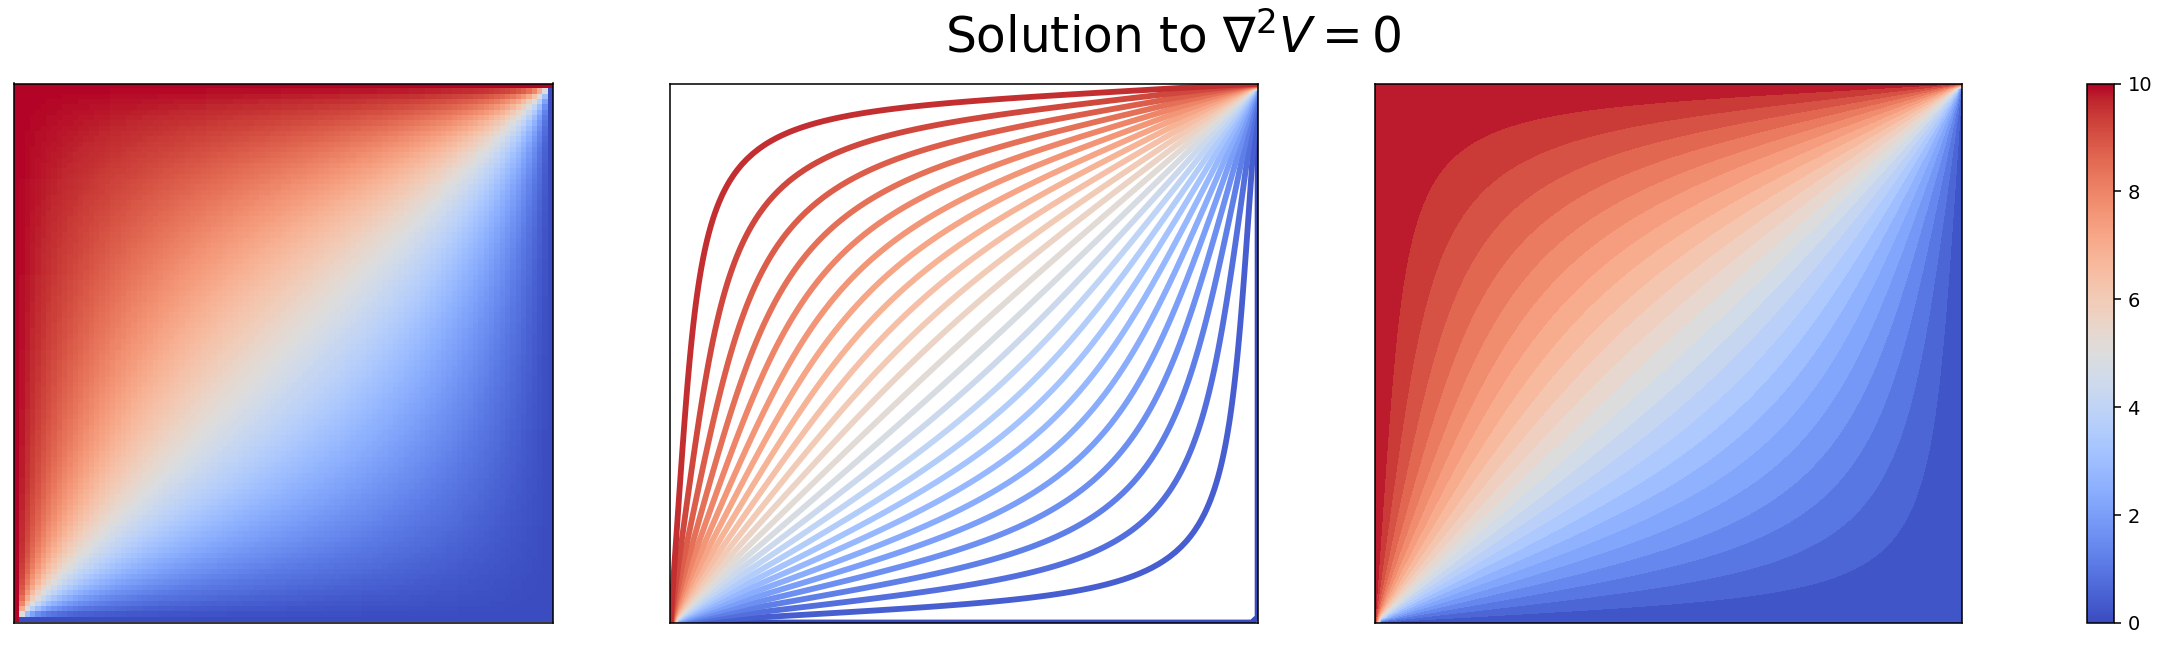

In [10]:
fig,ax = plt.subplots(1,3,figsize=[23,5],dpi=140)
img1 = ax[0].matshow(phi,cmap='coolwarm')
ax[1].contour(phi,linewidths=3,**kw)
ax[2].contourf(phi,**kw)
fig.colorbar(img1,ax=ax)

#removing any x or y labels
for i in range(3):
    ax[i].set_yticks([])
    ax[i].set_xticks([])

plt.suptitle(r"Solution to $\nabla^2 V = 0$",size = 25)
plt.show()

Now here is the 3D interactive plot.

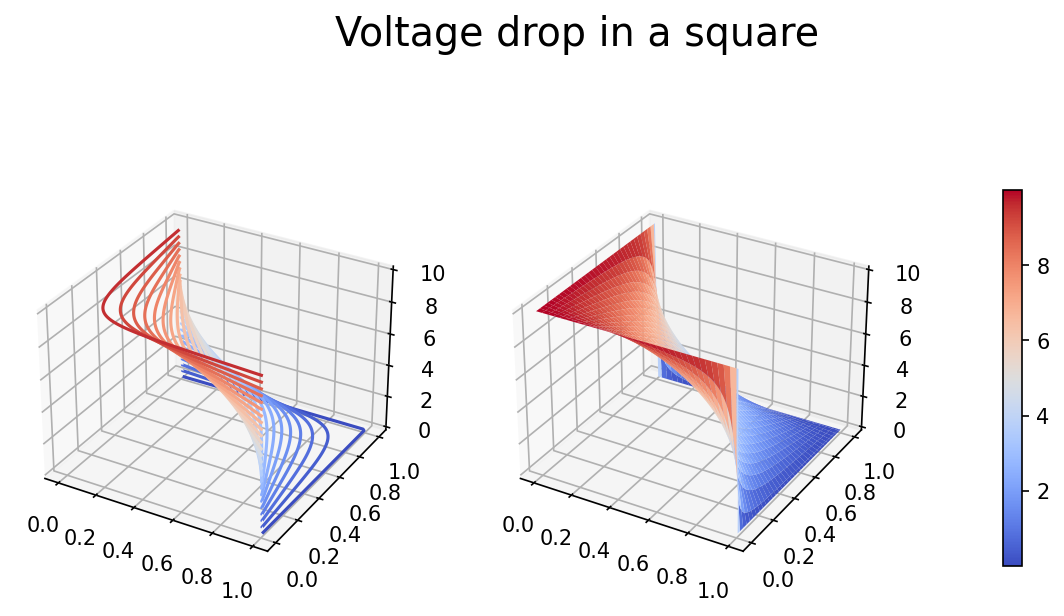

In [11]:
# to interact  with plot
# %matplotlib widget
# if it doesn't work or you just want to look at a static version use
# %matplotlib inline

XYvals = np.linspace(0,1,len(V))
X,Y = np.meshgrid(XYvals,XYvals)
kw = dict(cmap = "coolwarm", levels= 25, origin = "upper")

# plotting the surface and the contours
fig, ax = plt.subplots(1,2,figsize=[10,5],subplot_kw={'projection':'3d'},dpi =150)
ax[0].contour(X,Y,phi, **kw)
img = ax[1].plot_surface(X,Y,phi,cmap='coolwarm')

fig.colorbar(img,ax=ax,pad =.1, shrink = .65)
plt.suptitle("Voltage drop in a square",size=19)
plt.show()


## Problem 2
Use the relaxation method to calculate the potential of a two-dimensional parallel plate capacitor. You may assume that the plates are infinite in the z-direction so that it is a two dimensional calculation. I will be particularly interested in how well you reproduce the fringing field at the edges of the plates. You may assume that the plate potentials are +1 Volt for the bottom plate and -1 Volt for the top plate. Assume that the plates are separated by 1cm and are 20cm wide. Investigate how the size of your simulation relative to the width of the plates affects the fringing field. Assume the thickness of the plates is 25mm. Show plots of the equipotential contours

I first must change the boundary conditions as stated in the `compute` function before to match this problem.

Also, because we are now to solve the Poisson equation
$$ \nabla^2 V =- \frac{\rho}{\epsilon_0}$$

we have to adjust our function by adding a term.


Poisson's Equation takes the form

$$
\frac{\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y)}{a^2} =  -\frac{\rho(x,y)}{\epsilon_0}
$$

$$
\phi(x,y)= \frac14 [\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a)] + \frac{a^2}{4\epsilon_0} \rho(x,y)
$$

In [12]:
@nb.njit
def rho(x,y):
	"""
    The charge is located on the plates as follows
    V[30:45 , 50:250] = -1 # top side set to -1 V
    V[55:70:, 50:250] = 1 # bottom side set to 1 V
    """

	if x>30 and x<45 and y>50 and y<250:
		return -1
	elif x>55 and x<70 and y>50 and y<250:
		return 1
	else:
		return 0


In [13]:
@nb.njit
def relaxation(phi):
    a = 1
    epsilon0 = 1

    V = phi.copy()
    xpoints,ypoints = phi.shape
    Vprime = np.empty_like(V)
    delta = 10
    tolerance = 1e-6
    counter = 0
    while delta > tolerance:

        for i in range(xpoints):
            for j in range(ypoints):
                if i==0 or i==(xpoints-1) or j==0 or j==(ypoints-1):
                    Vprime[i,j] = V[i,j]
                else:
                    Vprime[i,j] = (V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1]) / 4 + a**2/(4*epsilon0)*rho(i*a,j*a)

        # Compute until convergence
        delta = np.max(np.abs(V - Vprime))

        # Swap the two arrays
        V,Vprime = Vprime,V
        counter+=1
        if counter > 1e6:
            break
    print("Number of iterations is",counter)

    return V

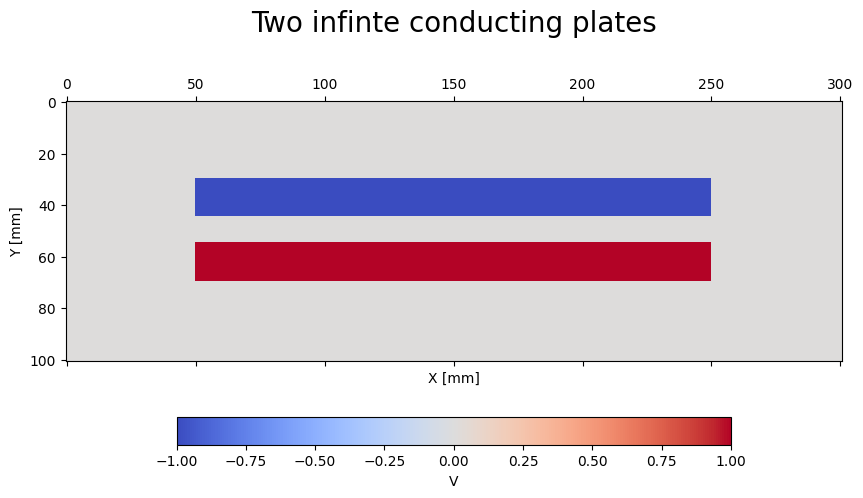

Number of iterations is 16975


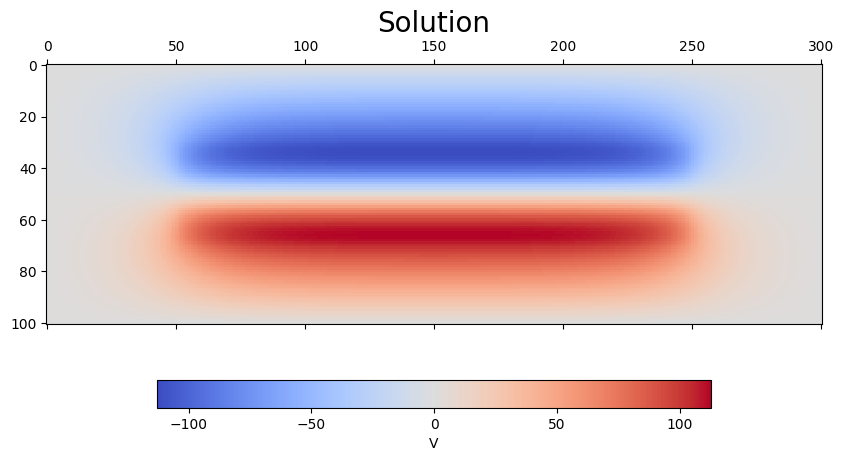

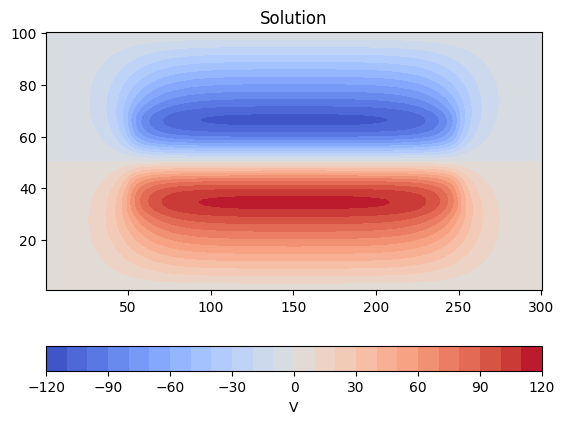

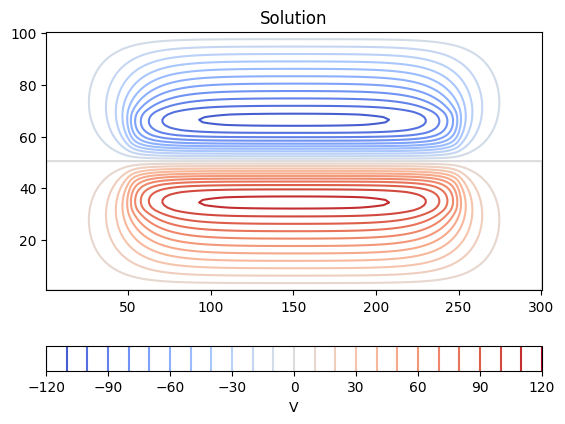

In [14]:
Nsquares = 100 # number of squares for each side (i.e. 100x100 total)
V = np.zeros([Nsquares+1,3*Nsquares+1]) # initialize an 100x100 array full of zeroes
V[30:45 , 50:250] = -1 # top side set to -1 V
V[55:70:, 50:250] = 1 # bottom side set to 1 V


plt.matshow(V,cmap='coolwarm')
plt.colorbar(location="bottom",label='V',shrink=.5)
plt.title("Two infinte conducting plates",size=20,pad=50)
plt.ylabel("Y [mm]")
plt.xlabel("X [mm]")
plt.show()

phi = relaxation(V)
plt.matshow(phi,cmap='coolwarm')
plt.title("Solution",size=20)
plt.colorbar(location="bottom",label="V",shrink = 0.5)
plt.show()

kw = dict(cmap = "coolwarm", levels= 25,origin='upper')


plt.contourf(phi,**kw)
plt.title("Solution")
plt.colorbar(location="bottom",label="V")
plt.show()

plt.contour(phi,**kw)
plt.title("Solution")
plt.colorbar(location="bottom",label="V")
plt.show()

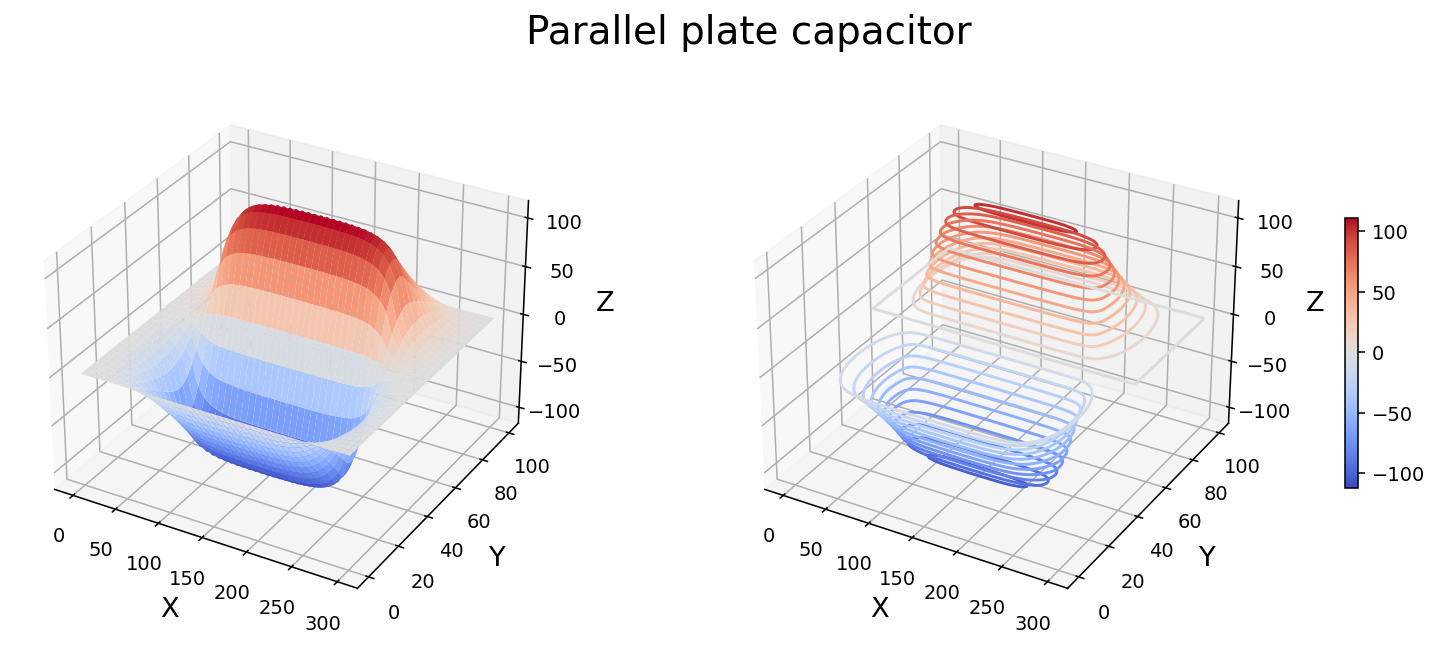

In [15]:
%matplotlib inline
y,x = V.shape
X = np.linspace(0,300,x)
Y = np.linspace(0,100,y)
X,Y = np.meshgrid(X,Y)
kw = dict(cmap = "coolwarm", levels= 25, origin = "upper")

fig,ax = plt.subplots(1,2,
                      figsize=[15,5],dpi=140,
                      subplot_kw={"projection":"3d"})

img = ax[0].plot_surface(X,Y,phi,cmap='coolwarm')
ax[1].contour(X,Y,phi,**kw)


kw = dict(labelpad = 5, size=14)
for i in range(2):
    ax[i].set_xlabel("X",**kw)
    ax[i].set_ylabel("Y",**kw)
    ax[i].set_zlabel("Z",**kw)
    ax[i].tick_params(axis='both', which='major', labelsize=10)
plt.colorbar(img,ax=ax,shrink=.5)
plt.suptitle("Parallel plate capacitor",size=20)

plt.show()